
# Title: **Comparison of Convolutional Neural Network and K-Nearest Neighbor for flood area classification using Sentinel-2**

**Note:** Please click this link https://uniofleicester-my.sharepoint.com/:f:/g/personal/acd34_student_le_ac_uk/Ehxhewto7UxJlq6gg_2ErqoBz1juJ_Xfscb0_cTwYtybMQ?e=wMKnMk in order to access all the neccasary data to reproduce my results. 

1) **pak_14_01_2020 and pak_25_09_2020** folders contains sentinel images without reprojection and clipping

2) **new_pak_14_01_2020 and new_pak_25_09_2020** folders contains sentinel images with reprojection and clipping

3) **Ajit_model.h5** is my CNN and **knn.sav** files is my trained model, you can just reload and perform the model evaluation.

4) **layers-2** is my shapefile folder used for clipping

#  Libraries

In [ ]:
# Load the Drive helper and mount your Google Drive as a drive in the virtual machine
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install earthpy


     |████████████████████████████████| 1.4MB 6.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.1MB 1.2MB/s 
     |████████████████████████████████| 1.0MB 44.1MB/s 
     |████████████████████████████████| 15.3MB 31.4MB/s 
     |████████████████████████████████| 6.5MB 50.5MB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp37-none-any.whl size=1365089 sha256=65f70d5073d495885565e3dd86b1375466b86b7b2a698f753d85a55ffbb164aa
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


In [ ]:
pip install fiona


In [ ]:
pip install rasterio==1.0.28

     |████████████████████████████████| 15.1MB 143kB/s 
  Found existing installation: rasterio 1.2.3
    Uninstalling rasterio-1.2.3:
      Successfully uninstalled rasterio-1.2.3


In [ ]:
#import required libraries
import pickle
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio.plot import show
from rasterio import plot
import fiona
from glob import glob
import os
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image
import fiona

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, accuracy_score
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [ ]:

from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import layers

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv
import seaborn as sns
from datetime import datetime

from scipy.io import loadmat
import time as t
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import concatenate, LayerNormalization, Multiply
from numpy import argmax


#  **Before Flooding:**

### Background:  https://earthobservatory.nasa.gov/images/147330/extreme-monsoon-rains-in-pakistan
#### Flood classification of Sindh province in southeastern Pakistan which is affected by heavy monsoon season has caused fatal flooding across Pakistan in 2020.More than 400 people have died since mid-June; another 400 were injured; and more than 200,000 homes were damaged or destroyed.

# Reprojection / clipping

For reprojection and clipping method I have followed:


1) https://stackoverflow.com/questions/58077960/unable-to-clip-image-using-rasterio-mask
 https://www.hatarilabs.com/ih-en/

2) https://www.hatarilabs.com/ih-en/how-to-clip-sentinel-2-bands-to-a-area-of-interest-with-python-rasterio-and-fiona-tutorial


In [ ]:
# Reprojecting the bands

dst_crs = 'epsg:4326' # Assigning the WGS84 as coordinate refrence system

# Open the file from "pak_14_01_2020" where the raw bands store without pre-processed 
# Tranform them to newly assinged CRS
# And save them in the new file called "new_pak_14_01_2020"
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_B03_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B03_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_B05_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B05_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_B06_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B06_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_B07_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B07_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_SCL_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_SCL_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_B8A_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B8A_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_WVP_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_WVP_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_B12_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B12_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
          
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_TCI_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_TCI_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_B02_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B02_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_B04_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B04_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_B11_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B11_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_14_01_2020/T42RVR_20200114T060211_AOT_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_AOT_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


In [ ]:
# clipping
imagePath = '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/'
bandNames = os.listdir(imagePath)
display(bandNames)

#import area of interest as Fiona geometry from the directory pakistan_layer -> POLYGON.shp
aoiFile = fiona.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pakistan_layer/POLYGON.shp')
aoiGeom = [aoiFile[0]['geometry']]

# clip all rasters
# Save it in the same file "new_pak_14_01_2020"
# Now all the processed bands in the file "new_pak_14_01_2020"
from rasterio.mask import mask
for band in bandNames:
    rasterPath = os.path.join(imagePath,band)
    rasterBand = rasterio.open(rasterPath)
    outImage, outTransform = mask(rasterBand, aoiGeom, crop=True)
    outMeta = rasterBand.meta
    outMeta.update({"driver": 'JP2OpenJPEG',
                 "height": outImage.shape[1],
                 "width": outImage.shape[2],
                 "transform": outTransform})
    outPath = os.path.join('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020',band)
    outRaster = rasterio.open(outPath, "w", **outMeta) 
    outRaster.write(outImage)
    outRaster.close()

# MNDWI 
Choosed MNDWI indice method from the literature **"Towards an automated approach to map flooded areas from Sentinel-2 MSI data and soft integration of water spectral features"**
 


In [ ]:
# Creating a variable with the file path for stacking the bands
before_floods = glob("/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/*20?*.jp2") 
before_floods.sort()
before_floods # Showing all the available bands which are pre-processed 

['/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B02_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B03_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B04_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B05_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B06_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B07_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B11_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T42RVR_20200114T060211_B12_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_14_01_2020/T4

In [ ]:
l= [] # empty list 
# for loop will iteratively read and add the bands in the empty l list
for i in before_floods:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))

# Now stack all the bands using np.stack method
before = np.stack(l)

In [ ]:
# showing all the shape of the bands
for i in range(0,12):
  print(l[i].shape)

(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)


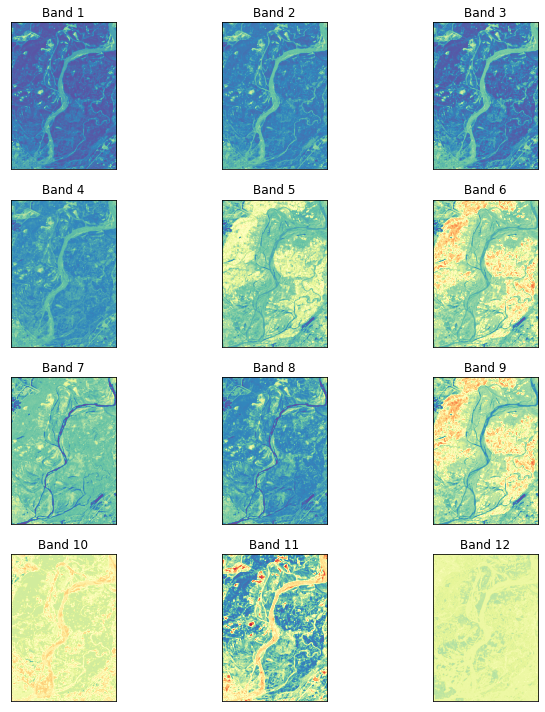

In [ ]:
# Visalize Bands
ep.plot_bands(before, cmap='Spectral_r', cols=3, figsize=(10, 10), cbar=False)

plt.show()

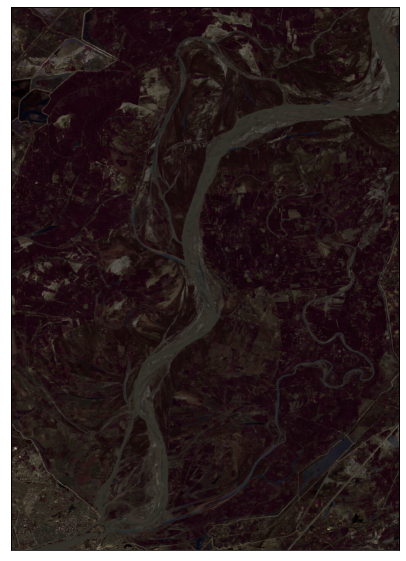

In [ ]:
# Visualize RGB Composite Image
ep.plot_rgb(before, rgb=(3, 2, 1), figsize=(10, 10))

In [ ]:
# Applying Modified Normalized Difference Water Index:
# MNDWI = (GREEN – SWIR1) / (GREEN + SWIR1)
# Sentinel 2 Green band is band 3 at 2
# Sentinel 2 SWIR band is band 11 at 7

# Calcualting MNDWI using earthpy libaray normalized_diff() function
mndwi_before = es.normalized_diff(before[7, :, :], before[2, :, :])

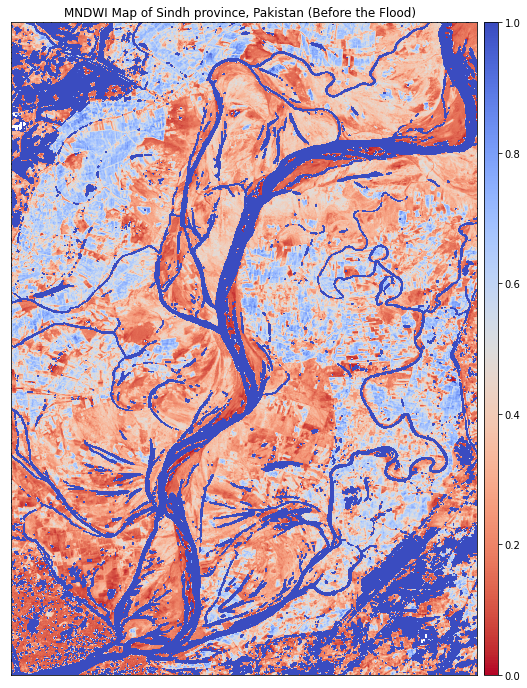

In [ ]:
titles = ["MNDWI Map of Sindh province, Pakistan (Before the Flood)  "]
ep.plot_bands(mndwi_before, cmap="coolwarm_r", title=titles,vmin=0, vmax=1)


# **After Flooding:**

# Reprojection / clipping

In [ ]:
# Reprojecting the bands

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'epsg:4326' # Assigning the WGS84 as coordinate refrence system

# Open the file from "pak_25_09_2020" where the raw bands store without pre-processed 
# Tranform them to newly assinged CRS
# And save them in the new file called "new_pak_25_09_2020"
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_25_09_2020/T42RVR_20200925T055639_B03_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B03_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_25_09_2020/T42RVR_20200925T055639_B05_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B05_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_25_09_2020/T42RVR_20200925T055639_B06_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B06_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_25_09_2020/T42RVR_20200925T055639_B07_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B07_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_25_09_2020/T42RVR_20200925T055639_SCL_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_SCL_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
           


with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_25_09_2020/T42RVR_20200925T055639_B8A_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B8A_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_25_09_2020/T42RVR_20200925T055639_TCI_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_TCI_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_25_09_2020/T42RVR_20200925T055639_B02_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B02_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_25_09_2020/T42RVR_20200925T055639_B04_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B04_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pak_25_09_2020/T42RVR_20200925T055639_B11_20m.jp2') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dst_crs, src.width, src.height, *src.bounds)
  kwargs = src.meta.copy()
  kwargs.update({
      'crs': dst_crs,
      'transform': transform,
      'width': width,
      'height': height
  })

  with rasterio.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B11_20m.jp2', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [ ]:
# clipping
imagePath = '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/'
bandNames = os.listdir(imagePath)
display(bandNames)

#import area of interest as Fiona geometry from the directory pakistan_layer -> POLYGON.shp
aoiFile = fiona.open('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/pakistan_layer/POLYGON.shp')
aoiGeom = [aoiFile[0]['geometry']]

# clip all rasters
# Save it in the same file "new_pak_25_09_2020"
# Now all the processed bands in the file "new_pak_25_09_2020"
from rasterio.mask import mask
for band in bandNames:
    rasterPath = os.path.join(imagePath,band)
    rasterBand = rasterio.open(rasterPath)
    outImage, outTransform = mask(rasterBand, aoiGeom, crop=True)
    outMeta = rasterBand.meta
    outMeta.update({"driver": 'JP2OpenJPEG',
                 "height": outImage.shape[1],
                 "width": outImage.shape[2],
                 "transform": outTransform})
    outPath = os.path.join('/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020',band)
    outRaster = rasterio.open(outPath, "w", **outMeta) 
    outRaster.write(outImage)
    outRaster.close()

# MNDWI

In [ ]:
# Creating a variable with the file path for stacking the bands
during_floods = glob("/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/*20?*.jp2")
during_floods.sort()
during_floods # Showing all the available bands which are pre-processed 

['/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_AOT_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B02_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B03_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B04_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B05_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B06_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B07_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T42RVR_20200925T055639_B11_20m.jp2',
 '/content/drive/MyDrive/Colab Notebooks/satellite_py/Data/new_pak_25_09_2020/T4

In [ ]:
dl = []# empty list 
# for loop will iteratively read and add the bands in the empty dl list
for i in during_floods:
  with rio.open(i, 'r') as f:
    dl.append(f.read(1))

# Now stack all the bands using np.stack method
arr_after = np.stack(dl)

In [ ]:
# showing all the shape of the bands
for i in range(0,12):
  print(dl[i].shape)

(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)
(1428, 1021)


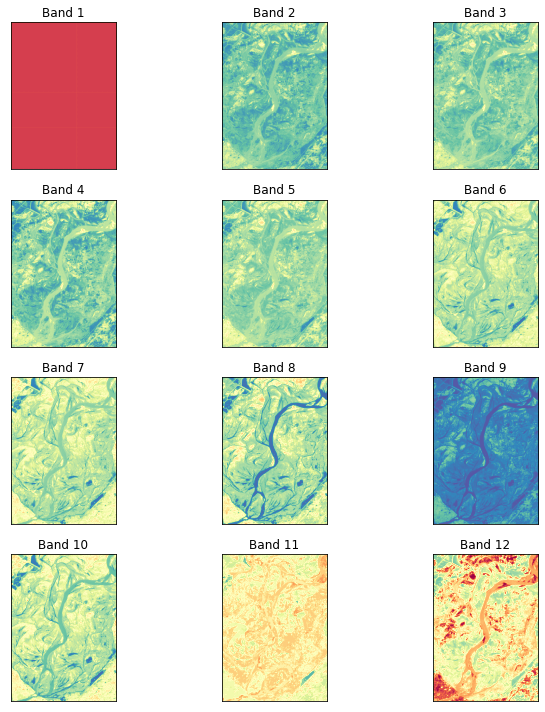

In [ ]:
# Visualize Bands
ep.plot_bands(arr_after, cmap='Spectral_r', cols=3, figsize=(10, 10), cbar=False)
plt.show()

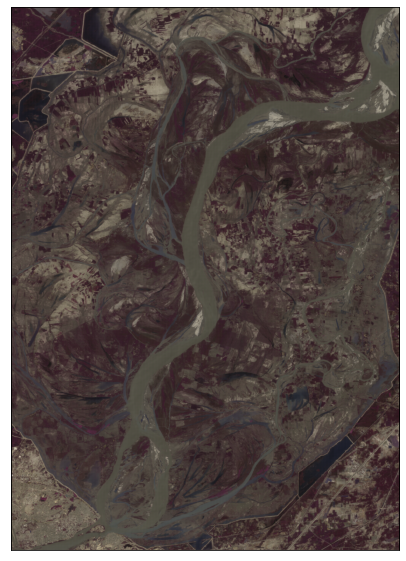

In [ ]:
# Visualize RGB Composite Image
ep.plot_rgb(arr_after, rgb=(4, 3, 2), figsize=(10, 10))

In [ ]:
# Applying Modified Normalized Difference Water Index:
# MNDWI = (GREEN – SWIR1) / (GREEN + SWIR1)
# Sentinel 2 Green band is band 3 at 3
# Sentinel 2 SWIR band is band 11 at 8

# Calcualting MNDWI using earthpy libaray normalized_diff() function
mndwi_after = es.normalized_diff(arr_after[8, :, :], arr_after[3, :, :])

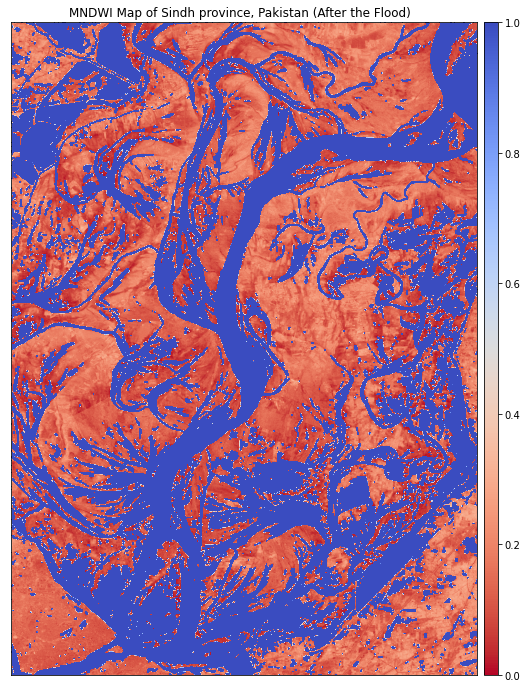

In [ ]:
titles = ["MNDWI Map of Sindh province, Pakistan (After the Flood)  "]
ep.plot_bands(mndwi_after, cmap='coolwarm_r',title=titles, vmin=0, vmax=1)

# Masking
Let's use MNDWI satellite images of before and after the floods for masking. This masking process will show the water pixels in the image with threshold of >0.6




In [ ]:
# Mask the data into water and non water pixels based on a threshold value(0.6)

mask_bef = (mndwi_before > 0.6).astype(int)

#ep.plot_bands(mask_bef, cmap='Greys_r', figsize=(12, 12))
#plt.show()

# Mask the data into water and non water pixels based on a threshold value(0.6)

mask_after = (mndwi_after > 0.6).astype(int)

#ep.plot_bands(mask_dur, cmap='Greys_r', figsize=(12, 12))
#plt.show()

In [ ]:
mask_bef.shape

(1428, 1021)

In [ ]:
mask_after.shape

(1428, 1021)

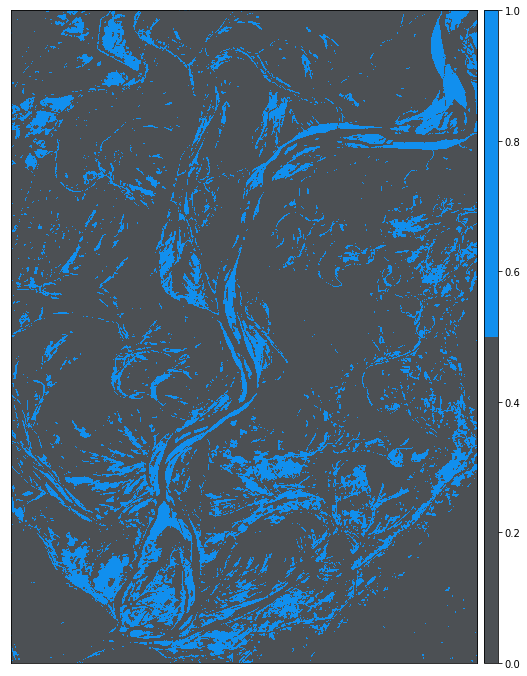

In [ ]:
# Now we use the masked images to find the area which affected by the flood 
mask_diff = (mask_after - mask_bef)
mask_diff = np.where(mask_diff <0, 0, mask_diff)

ep.plot_bands(mask_diff, cmap=ListedColormap([ '#4c5054','#118fee']), figsize=(12, 12))
plt.show() # The below image shows the area affected by the flood water in the Vivid blue color.

# Modelling

# KNeighbours classifier

In [ ]:
from sklearn.preprocessing import StandardScaler

x = np.moveaxis(arr_after, 0, -1) # using aftermat flood image as a x data

# Scalling the input features for improving the accuracy
X_data = x.reshape(-1, 12)
scaler = StandardScaler().fit(X_data)
X_scaled = scaler.transform(X_data) 

X_scaled.shape

(1457988, 12)

In [ ]:
# Let's use flood affected area image as a groundtruth in the model
y_data = mask_diff
y_data.shape

(1428, 1021)

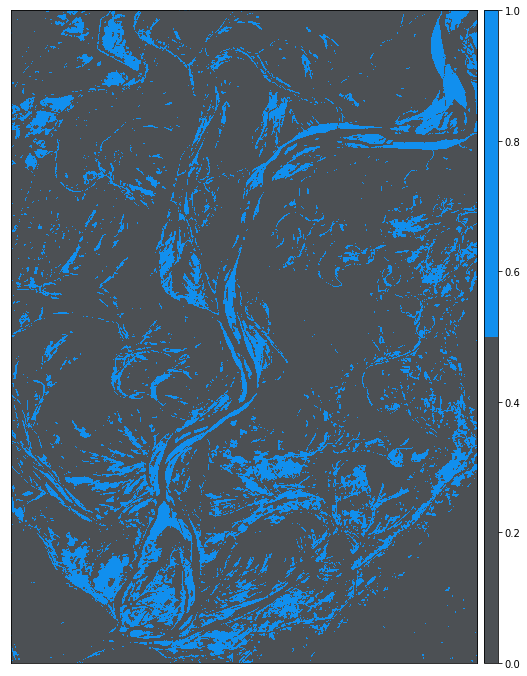

In [ ]:
# Visualize Groundtruth 
ep.plot_bands(y_data, cmap=ListedColormap([ '#4c5054','#118fee']))
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# 'X' is aftermath flood image data and 'y' is groundtruth data which indicate the area affected by the flood
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data.ravel(), test_size=0.30, stratify = y_data.ravel()) 
 

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (1020591, 12)
X_test Shape: (437397, 12)
y_train Shape: (1020591,)
y_test Shape:(437397,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Implemented KNeighborsClassifier with n_neighbors as 5
knn = KNeighborsClassifier(n_neighbors=5)

# And fits the train data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# pickle the model for future instant use
with open('knn.sav', 'wb') as f:
    pickle.dump(knn, f)

In [ ]:
knn_pred = knn.predict(X_test) # predict the labels of the test data
print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}") # shows the accuracy of the prediction

Accuracy: 92.30721747062736


In [ ]:
print(classification_report(y_test, knn_pred)) # The KNeighborsClassifier shows 90% accuracy 

              precision    recall  f1-score   support

           0       0.96      0.95      0.95    361170
           1       0.77      0.79      0.78     76227

    accuracy                           0.92    437397
   macro avg       0.86      0.87      0.87    437397
weighted avg       0.92      0.92      0.92    437397



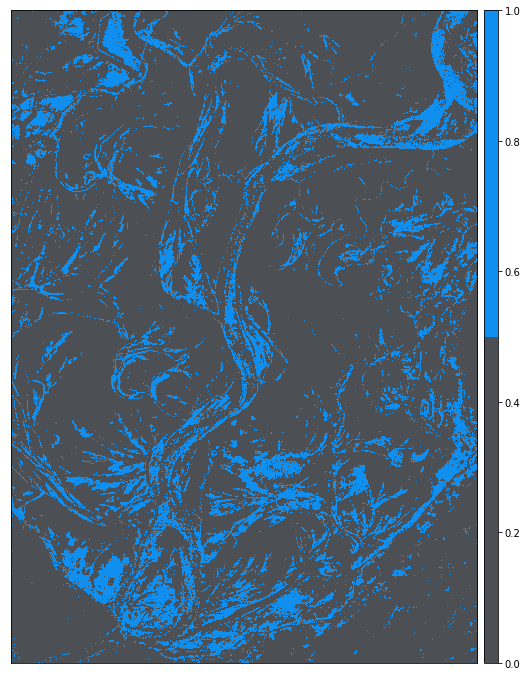

In [ ]:
# Visualize the KNeighborsClassifier map, which predict the area affected by the flood from the after flood image data.
ep.plot_bands(knn.predict(X_scaled).reshape(1428, 1021),cmap=ListedColormap([ '#4c5054','#118fee']))
plt.show()

In [ ]:
# load it back in
with open('knn.sav', 'rb') as f:
    knn = pickle.load(f)

# Convolutional Neural Network 
For applying CNN I have primarily followed:

1) https://github.com/codebasics/deep-learning-keras-tf-tutorial

2) https://keras.io/examples/vision/

3) https://github.com/syamkakarla98


In [ ]:

# Source: https://deeplizard.com/learn/video/qSTv_m-KFk0
# Help the model to to preserve the original input size. 
# This is required in  a per-convolutional layer basis. 
# And padding functionality helps to extract edge pixels, which can't peform in patch operation
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# I have created PCA funtion to reduce dimnesionailty and computation, And help to preserve spatail invaraince 
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

# Source: https://github.com/joaopfonseca/remote_sensing/blob/5cad616adb1173a1226be987782b812bf2e710eb/src/preprocess/utils.py
# In createImageCubes function path will extract each pixel and then created into a format that conforms to the keras processing
def createImageCubes(X, y, windowSize=5, removeZeroLabels = False):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
## GLOBAL VARIABLES
dataset = 'PK'
test_size = 0.20
windowSize = 15
MODEL_NAME = 'Pakistan'
path = '/content/drive/MyDrive/Colab Notebooks/satellite_py'

In [ ]:
X_data = np.moveaxis(arr_after, 0, -1) # using aftermat flood image as a x data
X_data.shape

(1428, 1021, 12)

In [ ]:
y_data = mask_diff ## Let's use flood affected area image as a groundtruth in the model
y_data.shape

(1428, 1021)

In [ ]:
# Apply PCA
K = 5
X,pca = applyPCA(X_data,numComponents=K)

print(f'Data After PCA: {X.shape}')

Data After PCA: (1428, 1021, 5)


In [ ]:
# Split train and test

X, y = createImageCubes(X, y_data, windowSize=windowSize)

print(f'Patch size: {X.shape}')


X_train, X_test, y_train, y_test = splitTrainTestSet(X, y, testRatio = test_size)

X_train = X_train.reshape(-1, windowSize, windowSize, K, 1)
X_test = X_test.reshape(-1, windowSize, windowSize, K, 1)

# One Hot Encoding - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Patch size: (1457988, 15, 15, 5)


In [ ]:
print(f'Train: {X_train.shape}\nTest: {X_test.shape}\nTrain Labels: {y_train.shape}\nTest Labels: {y_test.shape}')

Train: (1166390, 15, 15, 5, 1)
Test: (291598, 15, 15, 5, 1)
Train Labels: (1166390, 2)
Test Labels: (291598, 2)


In [ ]:
# Build a 3D convolutional neural network model
A = windowSize
B = K
output_units = y_train.shape[1]

## Defining Input layer
input_layer = Input((A, A, B, 1))

## This CNN architecture inspired by 
## https://keras.io/examples/vision/image_classification_from_scratch/ and 
## https://keras.io/examples/vision/3D_image_classification/
conv_layer1 = Conv3D(filters=20, kernel_size=(2, 2, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=40, kernel_size=(2, 2, 3), activation='relu')(conv_layer1)
conv2d_shape = conv_layer2.shape
conv_layer3 = Reshape((conv2d_shape[1], conv2d_shape[2], conv2d_shape[3]*conv2d_shape[4]))(conv_layer2)
conv_layer4 = layers.SeparableConv2D(filters=64, kernel_size=(2,2), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(128, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
dense_layer3 = Dense(20, activation='relu')(dense_layer2)
dense_layer3 = Dropout(0.4)(dense_layer3)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer3)
# define the model with input layer and output layer
model = Model(name = dataset+'_Model' , inputs=input_layer, outputs=output_layer)

model.summary()

Model: "PK_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 15, 5, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 14, 14, 3, 20)     260       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 13, 13, 1, 40)     9640      
_________________________________________________________________
reshape (Reshape)            (None, 13, 13, 40)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 12, 12, 64)        2784      
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               117

In [ ]:
# Compile
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Callbacks
# Tensorboard = path where saved all model performance in different vizualization form
logdir = path+"logs/" +model.name+'_'+datetime.now().strftime("%d:%m:%Y-%H:%M:%S")

tensorboard_callback = TensorBoard(log_dir=logdir)

# EarlyStopping function is a method use to reduce overfitting by terminating model training process if it's not improving loss or accuracy.
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 1,
                   verbose = 1,
                   restore_best_weights = True)

# Just like pickle function ModelCheckpoint help to save the model automatically after the training process is completed 
checkpoint = ModelCheckpoint(filepath = 'Ajit_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model.fit(x=X_train, y=y_train, 
                    batch_size=1024*6, epochs=15, 
                    validation_data=(X_test, y_test), callbacks = [tensorboard_callback, es, checkpoint])

Epoch 1/15
190/190 [==============================] - 100s 504ms/step - loss: 0.3681 - accuracy: 0.8027 - val_loss: 0.2302 - val_accuracy: 0.8852

Epoch 00001: val_loss improved from inf to 0.23021, saving model to Ajit_Model.h5
Epoch 2/15
190/190 [==============================] - 91s 481ms/step - loss: 0.2298 - accuracy: 0.8843 - val_loss: 0.2101 - val_accuracy: 0.8975

Epoch 00002: val_loss improved from 0.23021 to 0.21007, saving model to Ajit_Model.h5
Epoch 3/15
190/190 [==============================] - 91s 481ms/step - loss: 0.2121 - accuracy: 0.8958 - val_loss: 0.1967 - val_accuracy: 0.9059

Epoch 00003: val_loss improved from 0.21007 to 0.19672, saving model to Ajit_Model.h5
Epoch 4/15
190/190 [==============================] - 96s 503ms/step - loss: 0.1998 - accuracy: 0.9023 - val_loss: 0.1906 - val_accuracy: 0.9081

Epoch 00004: val_loss improved from 0.19672 to 0.19059, saving model to Ajit_Model.h5
Epoch 5/15
190/190 [==============================] - 95s 498ms/step - loss

In [ ]:
import pandas as pd
history = pd.DataFrame(history.history)

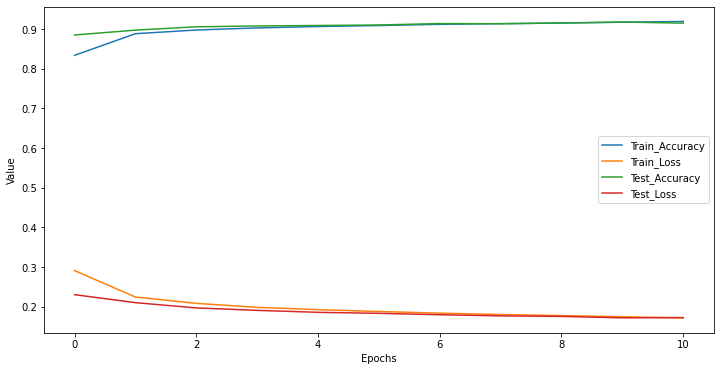

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/satellite_py/Ajit_Model.h5')

In [ ]:
pred = new_model.predict(X_test, batch_size=1204*6, verbose=1)

41/41 [==============================] - 6s 134ms/step


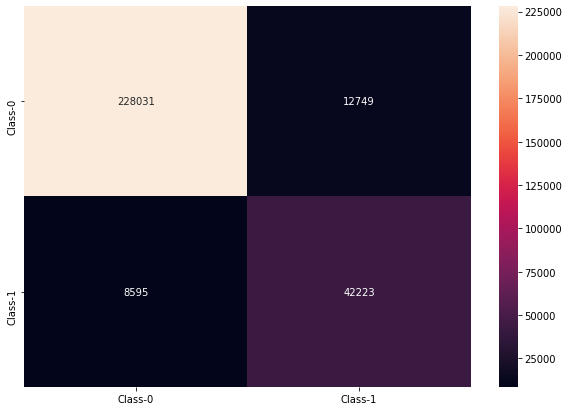

In [ ]:
import pandas as pd

plt.figure(figsize = (10,7))

classes = [f'Class-{i}' for i in range(0, 2)]

mat = confusion_matrix(np.argmax(y_test, 1),
                            np.argmax(pred, 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

In [ ]:
# Classification Report
print(classification_report(np.argmax(y_test, 1),
                            np.argmax(pred, 1),
      target_names = [f'Class-{i}' for i in range(0, 2)]))


              precision    recall  f1-score   support

     Class-0       0.96      0.95      0.96    240780
     Class-1       0.77      0.83      0.80     50818

    accuracy                           0.93    291598
   macro avg       0.87      0.89      0.88    291598
weighted avg       0.93      0.93      0.93    291598



In [ ]:
pred_t = new_model.predict(X.reshape(-1, windowSize, windowSize, K, 1),
                       batch_size=1204*6, verbose=1)

202/202 [==============================] - 30s 145ms/step


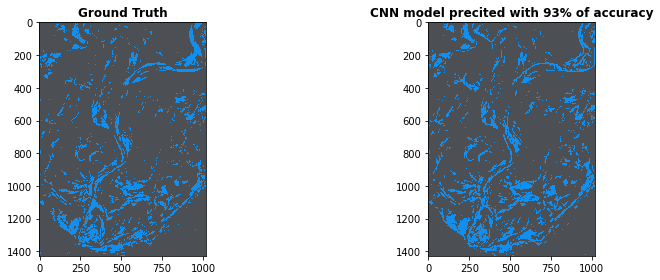

In [ ]:
# Result
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4))
fig.patch.set_facecolor('white')
plot.show(mask_diff, ax= ax1, cmap=ListedColormap([ '#4c5054','#118fee']), title="Ground Truth")
plot.show(np.argmax(pred_t, axis=1).reshape(1428, 1021), ax= ax2, cmap=ListedColormap([ '#4c5054','#118fee']), title="CNN model precited with 93% of accuracy")

fig.tight_layout()


In [ ]:
# Conclusion

For predicting area affected by the flood, Convolutional Neural Network perform better than traditional machine learning algorithm KNeighborsClassifier.